# Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks 
## Nils Reimers and Iryna Gurevych

https://arxiv.org/pdf/1908.10084.pdf

# 概要
BERTやRoBERTaなど事前学習をした言語モデルにより、STS(semantic textual similarity)など様々なタスクの精度が向上している。しかしながら、2つの文章を比較するタスクにおいては2つの文章を同時にネットワークに入力する必要がある。そのため、組み合わせ爆発が起こり計算時間が膨大になっていた。BERTでは10000文章の比較を実施すると5000万組の推論を行う必要があり、65時間を所要する。そのため類似度算出やクラスタリングに不適である。

そこで、本研究ではSentence-BERT(SBERT)を提案する。siamese and triplet networkを学習に使用し、コサイン類似度で文章の類似度を比較する。

# 新規性
- BERT, RoBERTaを用いてSBERTを構築したところ、BERTで65時間所要していた、最も類似した文章を検索するタスクが、5秒まで短縮された。
- その際、accuracyは保持された。
- STSや転移学習などのタスクにおいてSBERTはSOTAの他の手法を性能において上回った。

# SBERTの構造
- BERT or RoBERTaによる文章埋め込み
- Siamese network
- Pooling層

## 目的関数
- Classification Objective Function
- Regression Objective Function
- Triplet Objective Function

![fig1,2](./img/fig12.jpg)

**Classification Objective Function (Figure 1)** 2つの文章を独立してBERT(RoBERTa)で処理し、埋込表現を得た後、poolingし、ベクトルを結合し、訓練可能な重み行列を掛けてsoftmax関数に通過させる。そしてcross-entropy lossを最適化させる。

![eq1](./img/eq1.jpg)

**Regression Objective Function (Figure 2)** 2つの文章を独立してBERT(RoBERTa)で処理し、埋込表現を得た後、poolingし、コサイン類似度を算出する。mean-squared-error lossを最適化させる。

**Triplet Objective Function** 以下の3つの文から目的関数を構成し、最小化させる。
- a: anchor sentence
- p: positive sentence
- n: negative sentence

![eq2](./img/eq2.jpg)

マージンεは、pは最低でもnよりεだけaに近くなければいけないという意味である。

# SBERTのSTSでの評価
## 教師なしSTS
### 訓練条件
- classifier objective function
- SNLI and Multi-Genre NLI dataset
- batch size: 16
- optimizer: Adam
- learning rate 2e-5
- pooling strategy: mean

### 評価結果

![table1](./img/table1.jpg)

BERTの直接の出力や、BERTの埋め込みの平均などはGloVe埋め込みより低いスコアを示した。一方で、SBERT, SRoBERTaは他手法より高いスコアを示した。

SOTAの他手法は文埋め込みを複雑な回帰関数で類似スコアにマッピングしている。だが、その回帰関数は文章を組でしか扱えないため組み合わせ爆発を起こしスケーラブルではなかった。本研究ではコサイン類似度を使用することでその問題を解決している。

## 教師ありSTS
### 訓練条件
- regression objective function
- trained with 10 random seeds to counter variance
- データセット: STSb-base, STSb-large, NLI-STSb-base, NLI-STSb-large

### 評価結果
![table2](./img/table2.jpg)

4種類のデータセットで評価した結果、うち3種類でBERTが最高スコアを記録した。

# 計算効率

![table7](./img/table7.jpg)

GPUを用いた場合では、SBERTが最も計算効率が良かった。InferSentより9%, Universal Sentence Encoderより55%効率が向上した。ただ、Avg. BERT embeddingsやBERT CLS-vectorとの比較がない点は疑問が残る。

# 学んだこと
コサイン類似度の計算コストが非常に低いことは予想外だった。また、本手法によりBERTより大幅に計算時間を短縮して文章間の類似度を計算可能なことが分かった。計算量はO(n^2)で増加するため、nが非常に大きいデータの計算に有用であると考えられる。

# Trying SBERT

In [ ]:
# https://github.com/UKPLab/sentence-transformers
!pip install -U sentence-transformers

     ---------------------------------------- 86.0/86.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 6.8/6.8 MB 6.1 MB/s eta 0:00:00
     -------------------------------------- 172.3/172.3 MB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 9.0 MB/s eta 0:00:00
     ------------------------------------- 199.8/199.8 kB 12.6 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 6.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=03975f37c07dc9b675438be047d90ce2c5a543ac6f98b0ed717b5a4ea7947201
  Stored in directory: c:\users\kubor_000\appdata\local\pip\cache\wheels\71\67\06\162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-tran

## Trying SBERT on English Wikipedia data

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

以下のsentenceでは、1～3番目はNewyorkに関するwikipediaの記事から、4～6番目はFranceに関するwikipediaの記事から文を取得した。

In [ ]:
sentences = [
    'The city and its metropolitan area constitute the premier gateway for legal immigration to the United States',
    'As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world', 
    'New York City is home to more than 3.2 million residents born outside the U.S., the largest foreign-born population of any city in the world as of 2016',
    'Inhabited since the Palaeolithic era, the territory of Metropolitan France was settled by Celtic tribes known as Gauls during the Iron Age',
    'Rome annexed the area in 51 BC, leading to a distinct Gallo-Roman culture that laid the foundation of the French language',
    'The Germanic Franks formed the Kingdom of Francia, which became the heartland of the Carolingian Empire',]
sentence_embeddings = model.encode(sentences)


各文の組み合わせに対してSBERTで埋込表現を得て、コサイン類似度を計算した。

<AxesSubplot:>

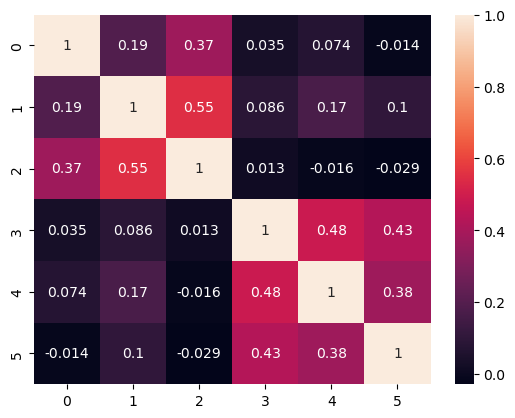

In [ ]:
import numpy as np
import seaborn as sns

def cosine_sim(s1, s2):
    return sum(s1 * s2) / np.sqrt(sum(s1 * s1)) / np.sqrt(sum(s2 * s2))

simmat = [[cosine_sim(s1, s2) for s1 in sentence_embeddings] for s2 in sentence_embeddings]

sns.heatmap(simmat, annot=True)


同じ記事から取った文同士は違う記事の文より高い類似度を示している。

## Trying SBERT on Japanese address data

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') # 多言語対応モデル

各文の組み合わせに対してSBERTで埋込表現を得て、コサイン類似度を計算した。

In [4]:
sentences = [
    '東京都新宿区弁天町１－１０７－３',
    '東京都新宿区弁天町１－107－３',
    '東京都新宿区弁天町１－１０７－2',
    '東京都新宿区弁天町１－107－３',
    '東京都新宿区弁天町１一１０７－３３３３３',
    '東京都新宿区弁天町１－１００７－３',
    '東京都新宿区弁天町１１－１０７一３',
    '東京都新宿区弁天町１－１０７-３',
    '東京都新宿区弁天町１－１１０７-３３',
    '東京都新宿区弁天町１－１０77－３',
    '東京都新宿区弁天町１－１７７－３',
    '東京都新宿区弁天町１１－１００７－３',
    '東京都新宿区弁天町１－１０７－３３３',
    '東京都新宿区歌舞伎町１－２－３',
    '東京都渋谷区宮益坂２２－７－１']
sentences_space = [' '.join(list(s)) for s in sentences] # 文字を半角スペース区切り
sentence_embeddings = model.encode(sentences_space)


各文の組み合わせに対してSBERTで埋込表現を得て、コサイン類似度を計算した。

<AxesSubplot:>

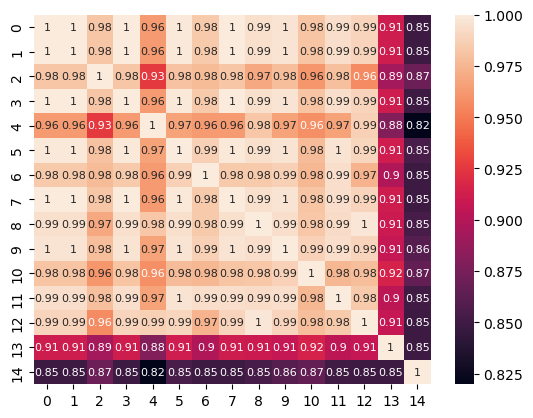

In [6]:
sns.heatmap(simmat, annot=True, annot_kws={"size":8})

表記ゆれ住所同士は、その他の住所より高い類似度を示している。